# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



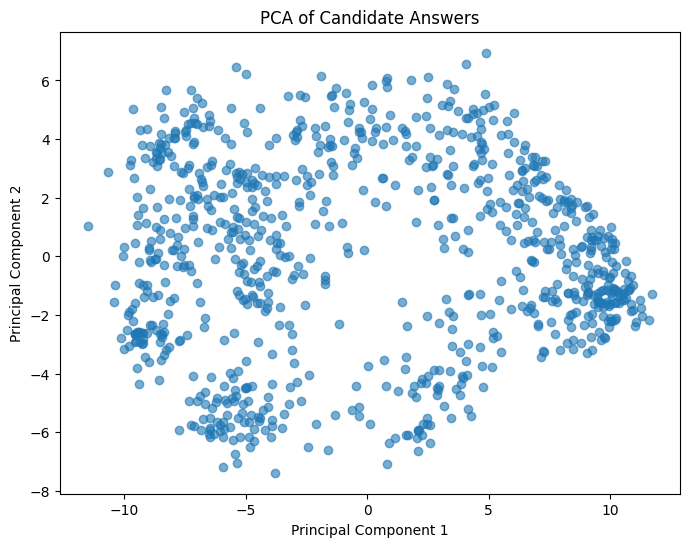

Top contributors to PC1:
531    0.205416
550    0.205066
3b     0.204075
544    0.185304
530    0.184872
dtype: float64


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = pd.read_excel('alldata.xlsx')
question_answers = [col for col in data.columns if col[0].isdigit()]

X = data[question_answers]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Candidate Answers")
plt.show()

loadings = pd.Series(pca.components_[0], index=X.columns).sort_values(ascending=False)
print("Top contributors to PC1:")
print(loadings.head(5))  

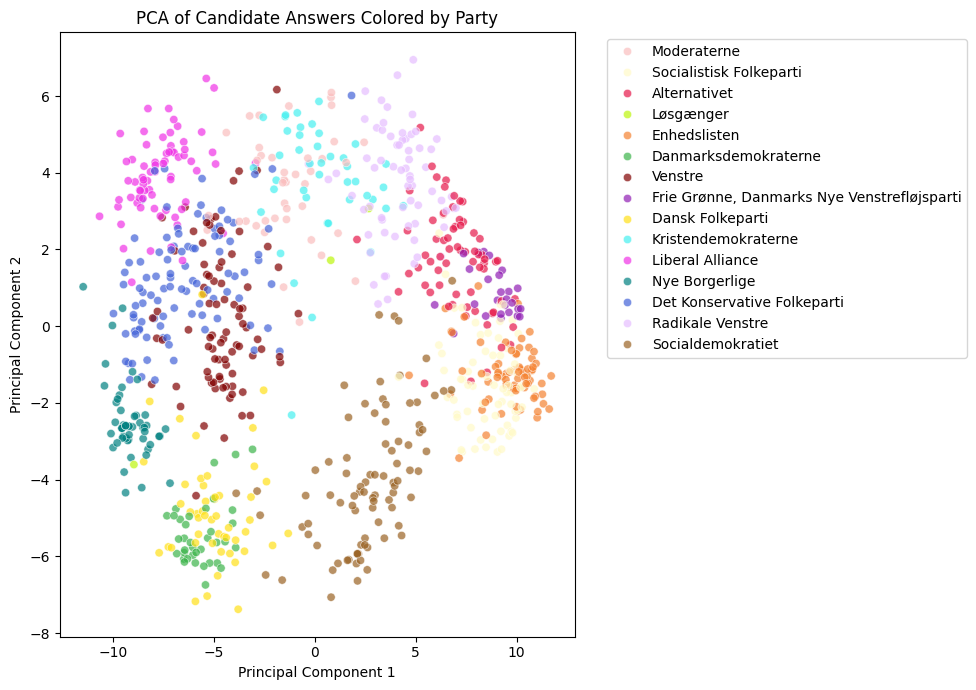

In [4]:
import seaborn as sns

X = data.drop(columns=['parti', 'navn', 'storkreds', 'alder'])  
y = data['parti']

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['parti'] = y.values

distinct_colors = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
    "#911eb4", "#46f0f0", "#f032e6", "#bcf60c", "#fabebe",
    "#008080", "#e6beff", "#9a6324", "#fffac8", "#800000"
]

party_list = sorted(pca_df['parti'].unique())
color_map = dict(zip(party_list, distinct_colors))


plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='parti', palette=color_map, alpha=0.7)

plt.title("PCA of Candidate Answers Colored by Party")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()

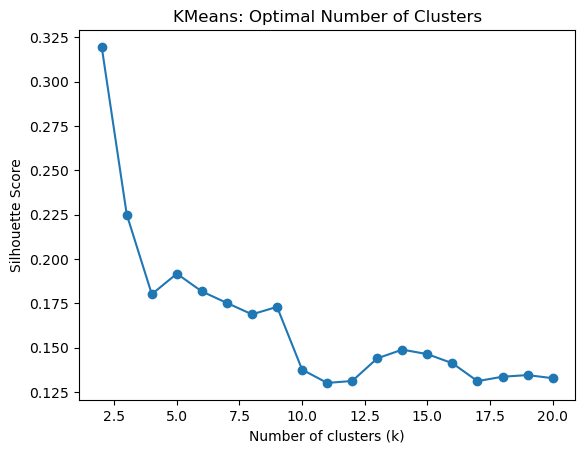

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os


silhouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('KMeans: Optimal Number of Clusters')
plt.show()


We should be looking for the "elbow" in the diagram, which is supposed to show the most optimal number of clusters that we need (the most optimal number of political parties in Denmark, in our case). There is an obvious and logical drop from 2 to 4 number of clusters. From 4 to 9 clusters, there is almost no difference and then from the 10th cluster, we can already see a lack of necessity in them. So, based on the KMeans algorithm, 4 to 9 clusters, 4 - 9 different political parties, would be enough to have in Denmark

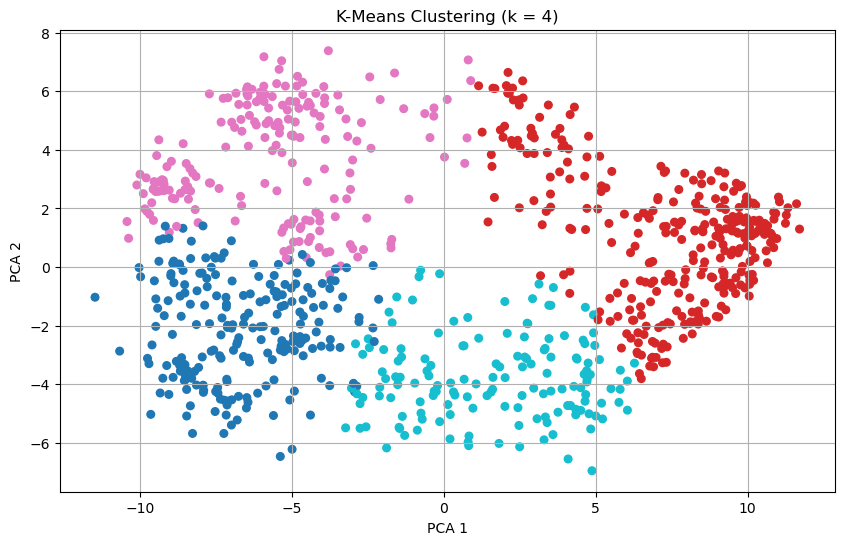

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', s=30)
plt.title("K-Means Clustering (k = 4)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

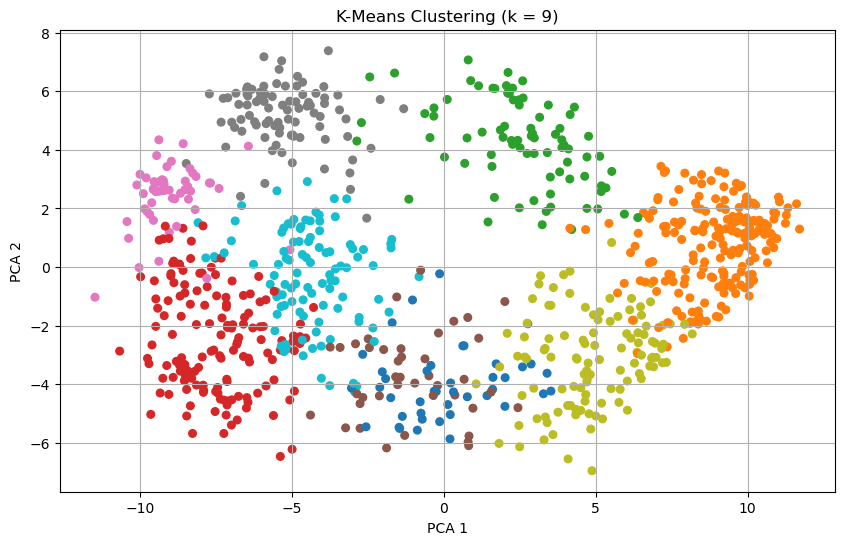

In [11]:
kmeans = KMeans(n_clusters=9, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', s=30)
plt.title("K-Means Clustering (k = 9)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

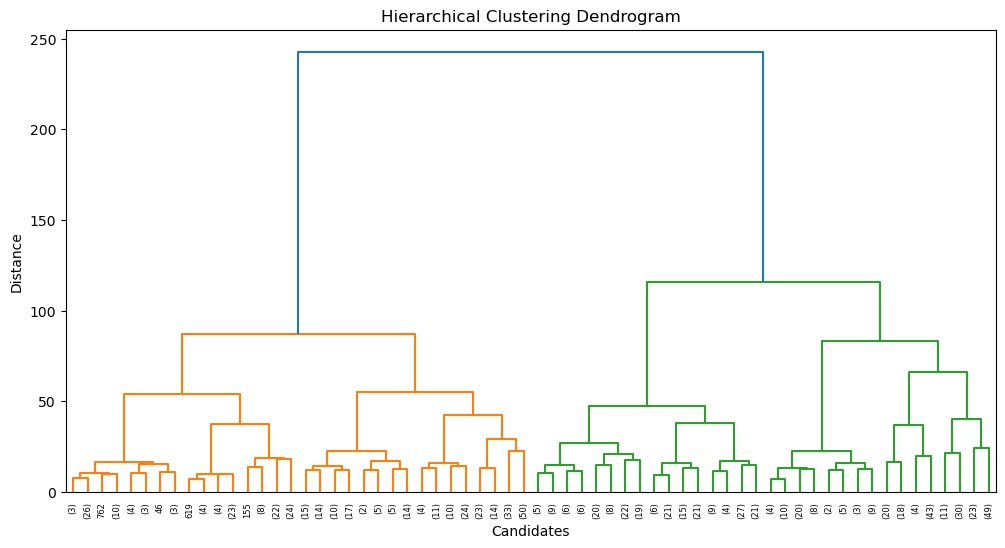

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

d_plot = linkage(X, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(d_plot, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Candidates")
plt.ylabel("Distance")
plt.show()

The right blue line shows the longest segment with no merging. Based on it and on the dendrogram, there can be 2 different clusters

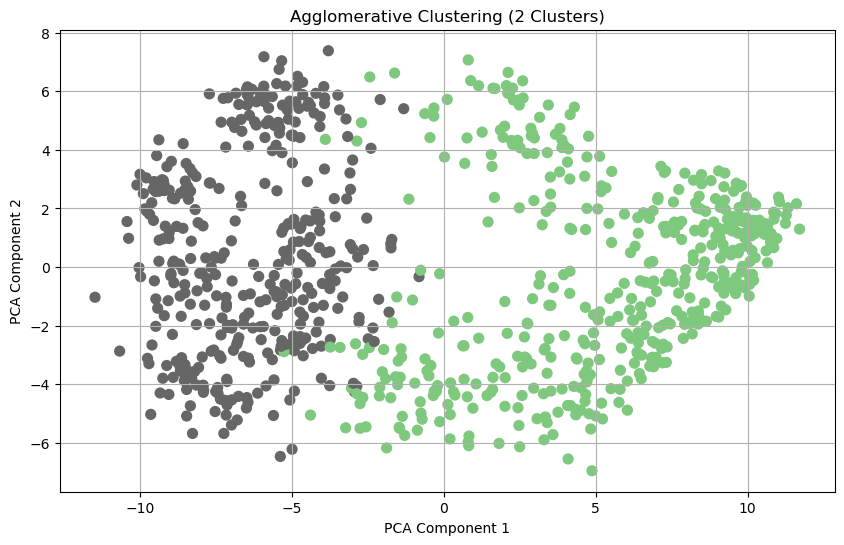

In [15]:
cluster_model = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels = cluster_model.fit_predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Accent', s=50)
plt.title("Agglomerative Clustering (2 Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

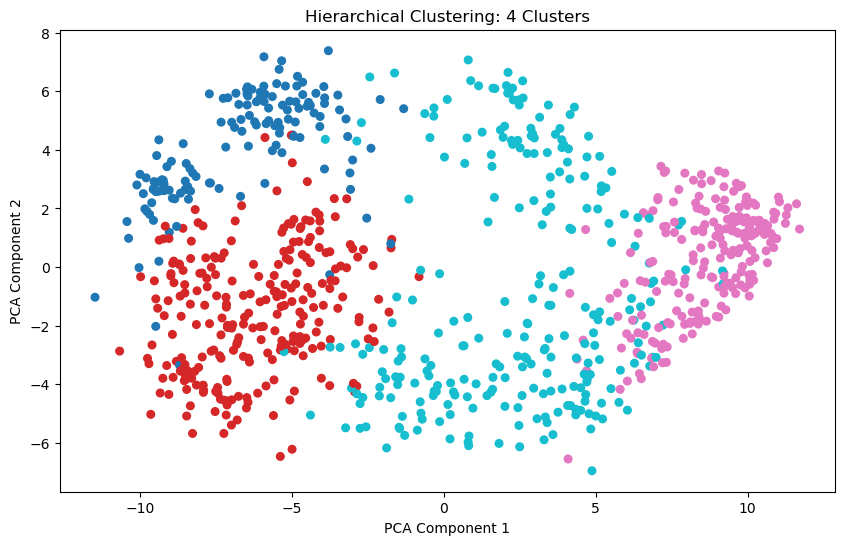

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
clusters = fcluster(d_plot, t=4, criterion='maxclust')

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', s=30)
plt.title("Hierarchical Clustering: 4 Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

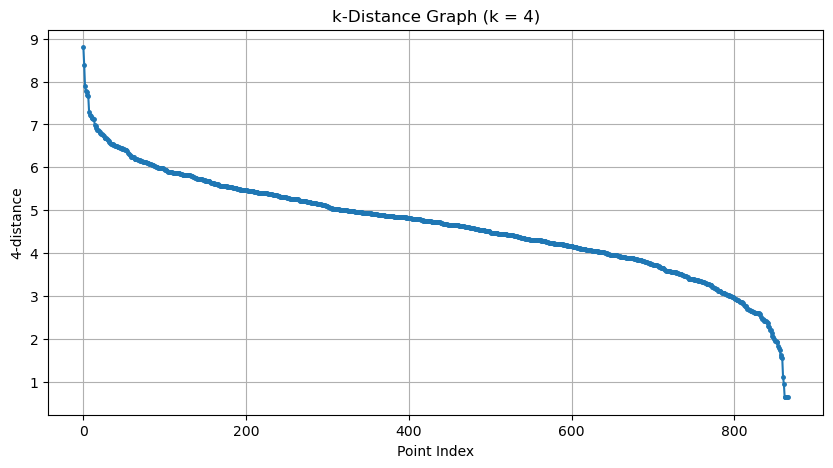

In [19]:
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)

def calculate_k_distance(X, k):
    k_distance = []
    for i in range(len(X)):
        dist = []
        for j in range(len(X)):
            dist.append(np.linalg.norm(X[i, :] - X[j, :]))
        dist.sort()
        k_distance.append(dist[k])  
    k_distance.sort(reverse=True)
    return k_distance

k = 4  
k_distances = calculate_k_distance(X_scaled, k)

plt.figure(figsize=(10, 5))
plt.plot(range(len(X_scaled)), k_distances, '.-', markersize=5)
plt.xlabel('Point Index')
plt.ylabel(f'{k}-distance')
plt.title(f'k-Distance Graph (k = {k})')
plt.grid(True)
plt.show()



Number of clusters: 6
Number of noise points (outliers): 538


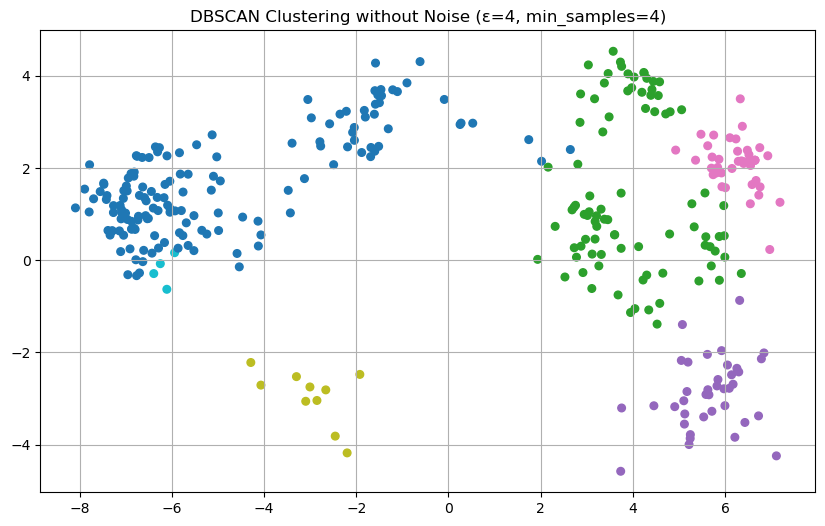

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

dbscan = DBSCAN(eps=4, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points (outliers): {n_noise}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

mask = dbscan_labels != -1
X_pca_filtered = X_pca[mask]
labels_filtered = dbscan_labels[mask]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca_filtered[:, 0], X_pca_filtered[:, 1], c=labels_filtered, cmap='tab10', s=30)
plt.title("DBSCAN Clustering without Noise (ε=4, min_samples=4)")
plt.grid(True)
plt.show()

In [23]:
eps_values = [2, 3, 4, 5, 6]
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=4).fit(X_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"ε = {eps}: clusters = {n_clusters}, noise = {n_noise}")


ε = 2: clusters = 3, noise = 843
ε = 3: clusters = 7, noise = 759
ε = 4: clusters = 6, noise = 538
ε = 5: clusters = 1, noise = 213
ε = 6: clusters = 1, noise = 46


After doing a DBSCAN, it creates 6 clusters and leaves other 538 candidates unattached to any cluster. 6 clusters suggest that there are 6 groups of people in the Danish Parliament that think in distinct ways (have the same ideas/beliefs). This could mean that instead of 15 parties, there could be 6 instead. Regarding the other 538 candidates who do not fit any cluster, their ideas are more "centrist", they incorporate beliefs from every cluster, which doesn't make them a candidate of a one, specific group.

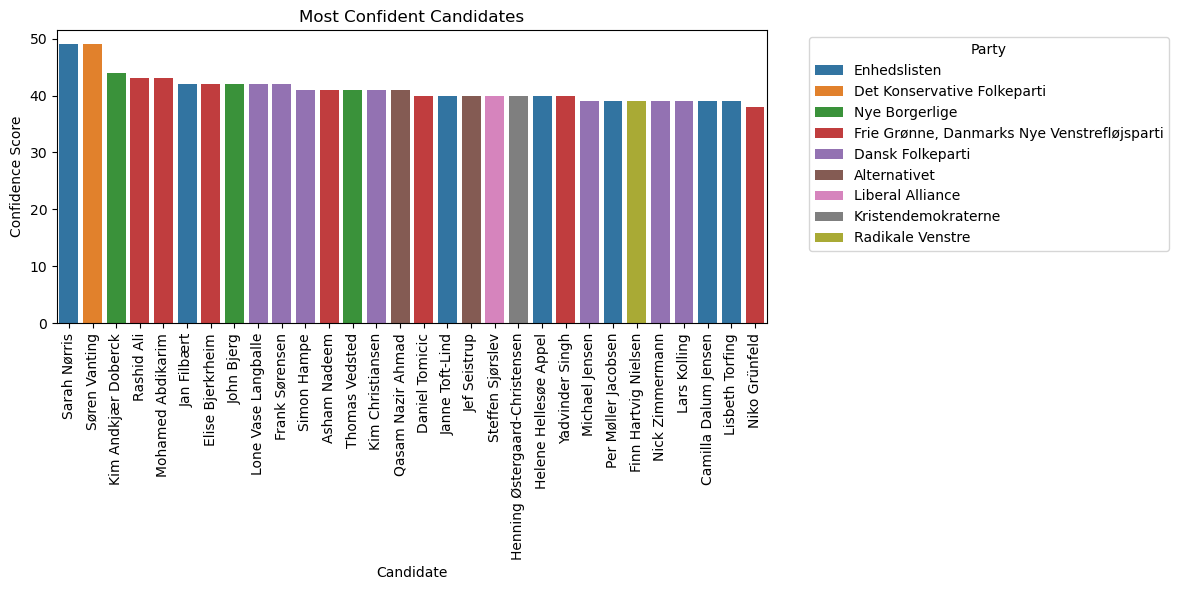

In [25]:
#overview of the most confident candidates

question_answers = [col for col in data.columns if col[0].isdigit()]
data["confidence_score"] = (data[question_answers] == -2).sum(axis=1) + (data[question_answers] == 2).sum(axis=1)
result = data[["navn", "parti", "confidence_score"]].sort_values(by="confidence_score", ascending=False)
most_confident = result.head(30)

plt.figure(figsize=(12, 6))
sns.barplot(x="navn", y="confidence_score", hue="parti", data=most_confident, dodge=False, palette="tab10")

plt.title("Most Confident Candidates")
plt.xlabel("Candidate")
plt.ylabel("Confidence Score")
plt.xticks(rotation=90)
plt.legend(title="Party", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


data = data.drop(['confidence_score'], axis=1)

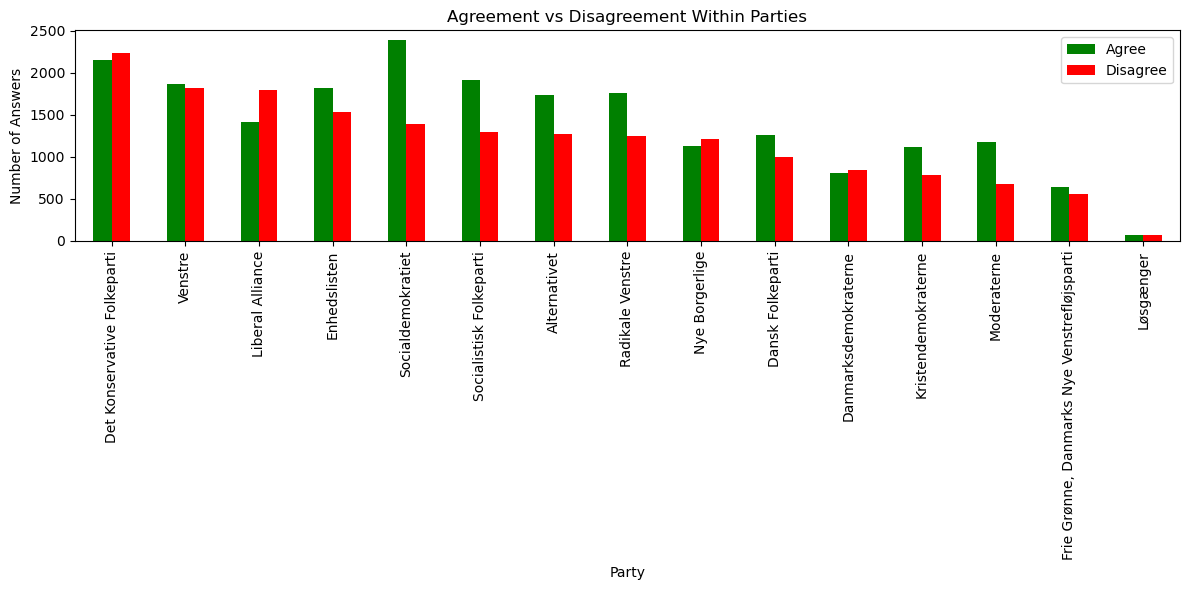

In [27]:
question_columns = [col for col in data.columns if col[0].isdigit()]

data["disagree_count"] = (data[question_columns] == -2).sum(axis=1) + (data[question_columns] == -1).sum(axis=1)
data["agree_count"] = (data[question_columns] == 1).sum(axis=1) + (data[question_columns] == 2).sum(axis=1)

party_agree_disagree = data.groupby("parti")[["agree_count", "disagree_count"]].sum().sort_values(by="disagree_count", ascending=False)

party_agree_disagree.plot(kind='bar', figsize=(12, 6), color=["green", "red"])
plt.title("Agreement vs Disagreement Within Parties")
plt.xlabel("Party")
plt.ylabel("Number of Answers")
plt.xticks(rotation=90)
plt.legend(["Agree", "Disagree"])
plt.tight_layout()
plt.show()

data = data.drop(["agree_count", "disagree_count"], axis=1)